In [26]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from data_utils.acdc_datamodule import ACDCDataModule


In [27]:

datamodule = ACDCDataModule("ACDC", 32,32,32,(256,256,1))

In [28]:
path = "database/training/patient001/patient001_frame01_gt.nii.gz"
p001_gt = nib.load(path).get_fdata()
p001_gt = np.transpose(p001_gt, (2,0,1) )

p001_gt.shape

(10, 216, 256)

In [29]:
path = "database/training/patient001/patient001_frame01.nii.gz"
p001_img = nib.load(path).get_fdata()
p001_img = np.transpose(p001_img, (2,0,1) )

p001_img.shape

(10, 216, 256)

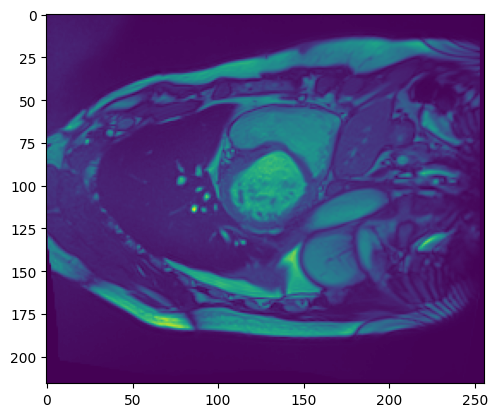

In [30]:
plt.imshow(p001_img[1])

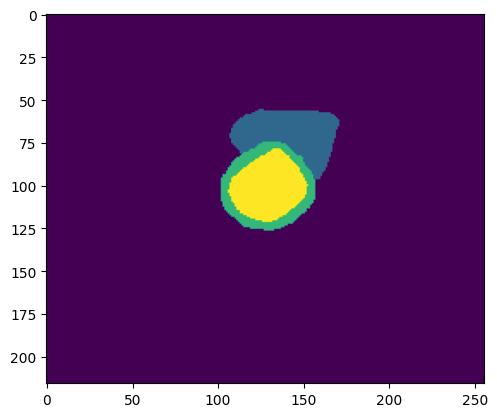

In [31]:
plt.imshow(p001_gt[1])

In [32]:
# split the multi-class masks into submasks
mask0 = np.where(p001_gt[:,:] == 0, 1,0)
mask1 = np.where(p001_gt[:,:] == 1, 1,0)
mask2 = np.where(p001_gt[:,:] == 2, 1,0)
mask3 = np.where(p001_gt[:,:] == 3, 1,0)
masked_img_0 = p001_img * mask0
masked_img_1 = p001_img * mask1
masked_img_2 = p001_img * mask2
masked_img_3 = p001_img * mask3
masked_images = [masked_img_0, masked_img_1, masked_img_2, masked_img_3]
masked_images[0].shape
masks = [mask0, mask1, mask2, mask3]


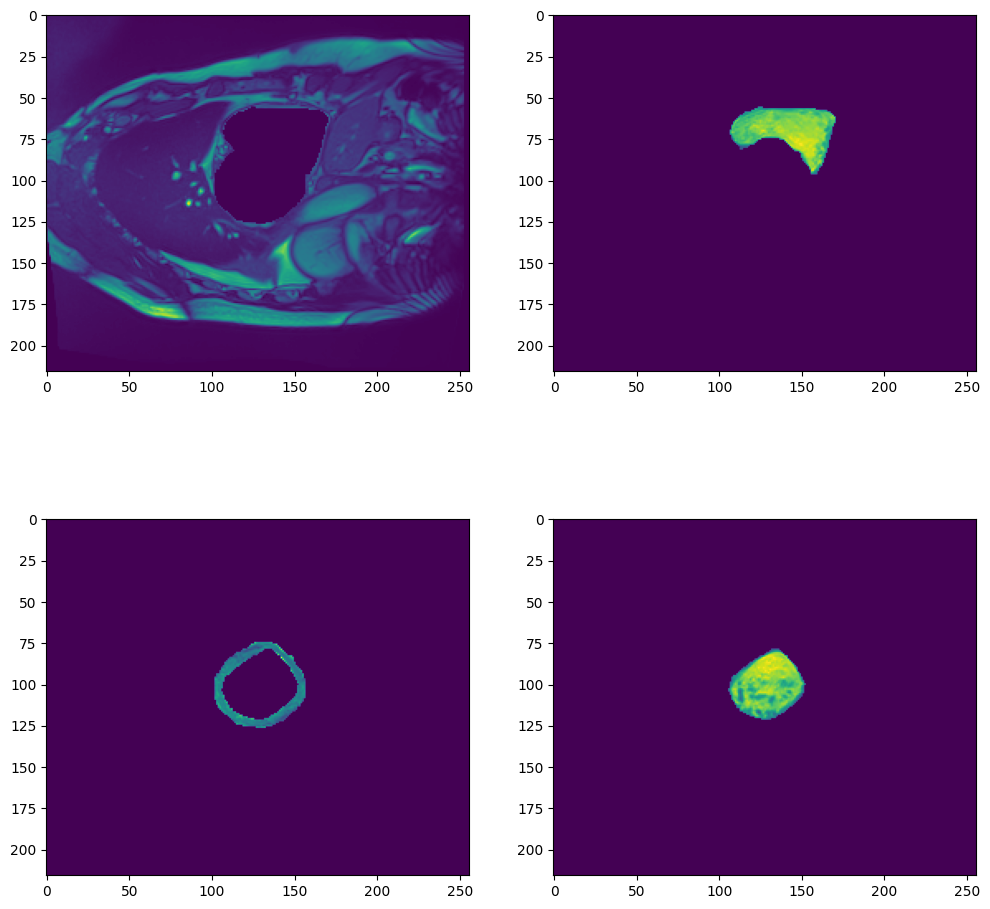

In [33]:
plt.style.use('default')
fig, axes = plt.subplots(2,2, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(masked_images[i][1])
plt.show()

In [34]:
def visualize(image_raw,mask):
    """
    iamge_raw:gray image with shape [width,height,1]
    mask: segment mask image with shape [num_class,width,height]
    this function return an image using multi color to visualize masks in raw image
    """
    # Convert grayscale image to RGB
    image = cv2.cvtColor(image_raw, cv2.COLOR_GRAY2RGB)
    
    # Get the number of classes (i.e. channels) in the mask
    num_class = mask.shape[0]
    
    # Define colors for each class (using a simple color map)
    colors = []
    for i in range(1, num_class):  # skip first class (background)
        hue = int(i/float(num_class-1) * 179)
        color = np.zeros((1, 1, 3), dtype=np.uint8)
        color[0, 0, 0] = hue
        color[0, 0, 1:] = 255
        color = cv2.cvtColor(color, cv2.COLOR_HSV2RGB)
        colors.append(color)

    # Overlay each non-background class mask with a different color on the original image
    for i in range(1, num_class):
        class_mask = mask[i, :, :]
        class_mask = np.repeat(class_mask[:, :, np.newaxis], 3, axis=2)
        class_mask = class_mask.astype(image.dtype)
        class_mask = class_mask * colors[i-1]
        image = cv2.addWeighted(image, 1.0, class_mask, 0.5, 0.0)

    return image

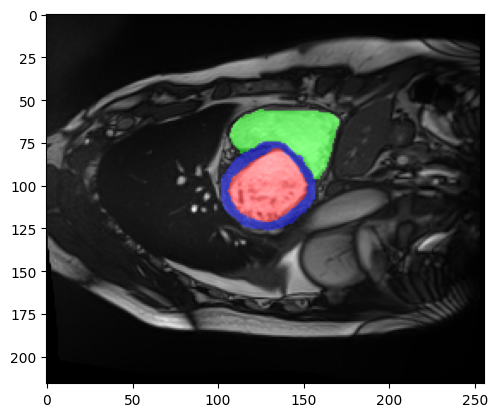

In [35]:
masks = np.array(masks)
masks = np.transpose(masks, (1,0,2,3))
normalized_image = cv2.normalize(p001_img[1], None, 0, 255, cv2.NORM_MINMAX)
normalized_image = normalized_image.astype(np.uint8)
vis_img = visualize(normalized_image, masks[1])

plt.imshow(vis_img)

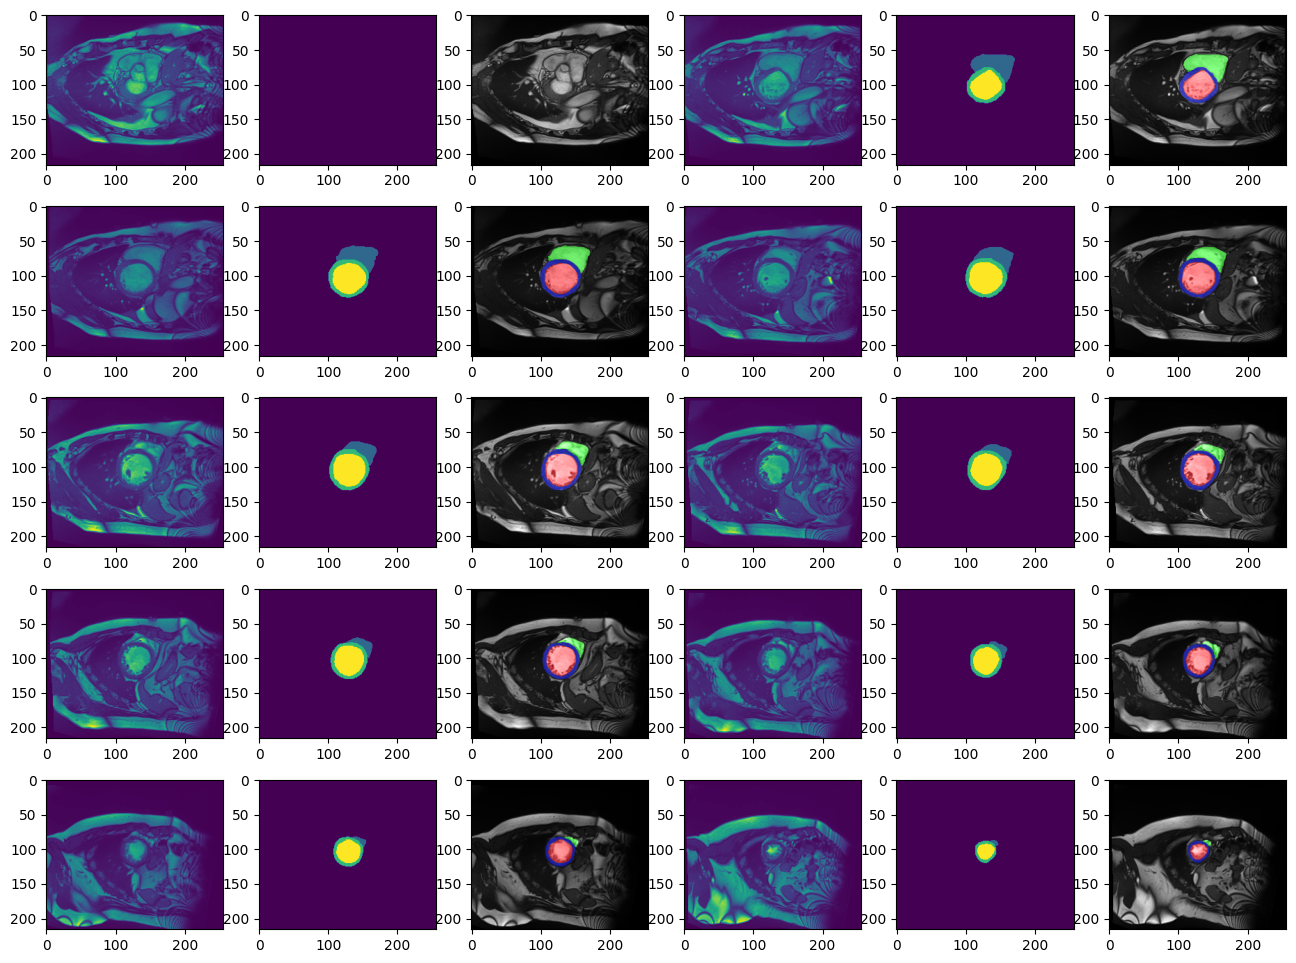

In [36]:
plt.style.use('default')
fig, axes = plt.subplots(5,6, figsize=(16,12))
for i, ax in enumerate(axes.reshape(-1)):
    if i % 3 == 0:
        ax.imshow(p001_img[i//3,:,:])
    elif i % 3 == 1:
        ax.imshow(p001_gt[i//3,:,:])
    else:
        normalized_image = cv2.normalize(p001_img[i//3], None, 0, 255, cv2.NORM_MINMAX)
        normalized_image = normalized_image.astype(np.uint8)
        vis_img = visualize(normalized_image, masks[i//3])
        ax.imshow(vis_img)
plt.show()

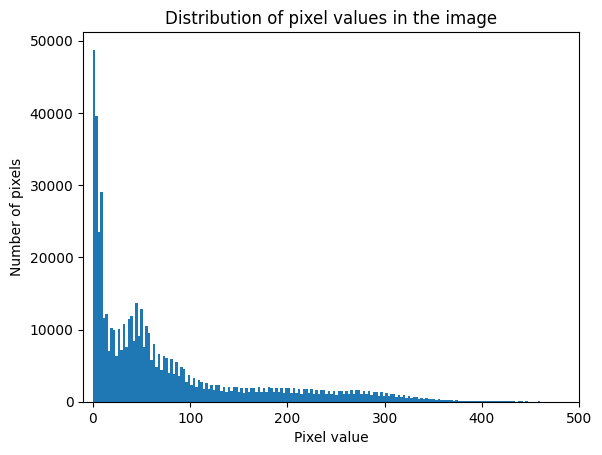

In [37]:
plt.hist(p001_img.flatten(), bins=256)
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.title('Distribution of pixel values in the image')
plt.xlim(-10,500)
plt.show()

In [38]:
np.count_nonzero((p001_gt[1,:,:] == 0))
size = p001_gt[0].shape
size[0]*size[1]

def get_label_percentages(label_img):
    size = label_img.shape
    pixel_count = size[0]*size[1]
    percs = []
    for i in range(4):
        percs += [np.count_nonzero((label_img[:,:] == i))/pixel_count]
    return percs
    

In [39]:
from data_utils.data_utils import get_acdc

acdc_data, _, _ = get_acdc(path="database/training")

## Infos about the patients

In [40]:
import pandas as pd
info_df = pd.DataFrame.from_dict(acdc_data[2])

types = ['int64', 'int64', 'string', 'float32', 'int64', 'float32']
column_types_dict = dict(zip(info_df.columns, types))

info_df = info_df.astype(column_types_dict)

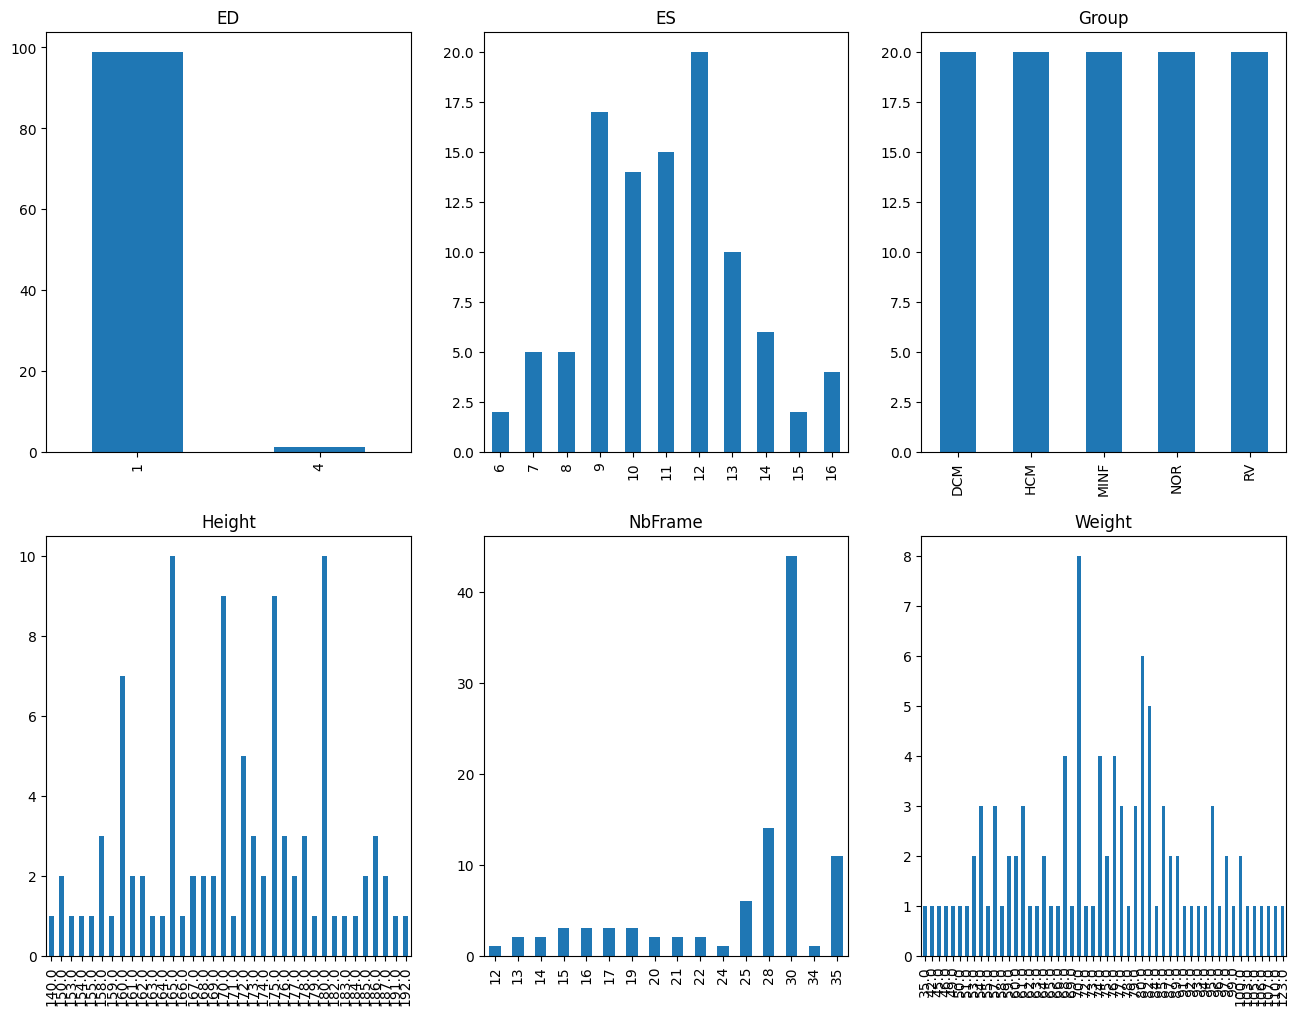

In [41]:
fig, axes = plt.subplots(2,3, figsize=(16,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.title.set_text(info_df.columns[i])
    info_df[info_df.columns[i]].value_counts().sort_index().plot(kind='bar', ax=ax)
plt.show()

## Percentages of pixels in labeled images
Grouped by the patient groups

In [42]:
percs = []
for i, l in enumerate(acdc_data[1]):
    percs.append(get_label_percentages(l))


In [43]:
columns = ['background','RV','myocardium','LV']
percs_df = pd.DataFrame(percs, columns=columns)

In [44]:
groups = info_df['Group'].value_counts().index

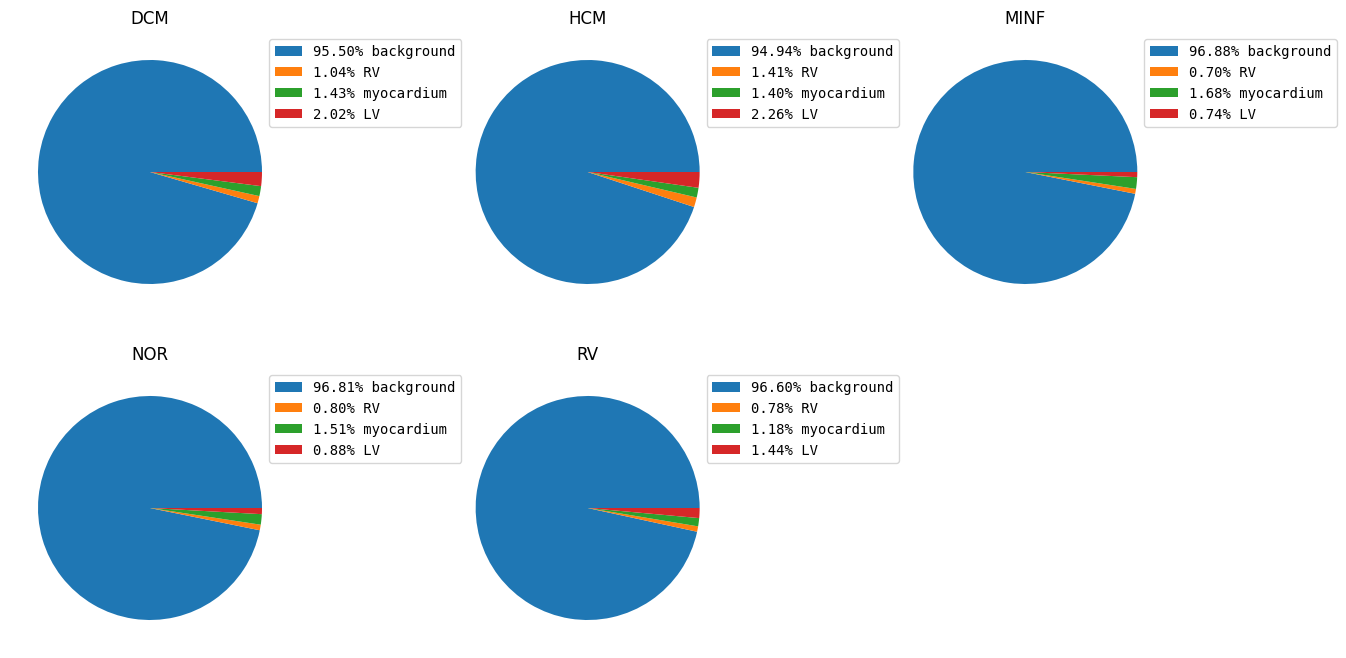

In [45]:

fig, axes = plt.subplots(2,3, figsize=(16,8))
for i, ax in enumerate(axes.reshape(-1)):
    if i < 5:
        ax.title.set_text(groups[i])
        start = i*20*10
        end = (i*20+20)*10
        data = percs_df[start:end].mean()
        labels = []
        for l, v in zip(data.index , data.values):
            labels.append(format(v, ".2%") + " " + l)
        ax.pie(data.values, radius=1)
        ax.legend(labels, bbox_to_anchor=(0.9, 1), prop={'family': 'DejaVu Sans Mono'})
    else:
        ax.set_visible(False)
plt.show()

### Variance of percentages

In [46]:
percs_df.std()

background    0.022305
RV            0.011994
myocardium    0.006642
LV            0.009289
dtype: float64